 # TP 2 

### l’algorithme quantique de Deutsch-Jozsa
##### Implémentation de l’algorithme quantique de Deutsch-Jozsa à l’aide de Qiskit, et son exécutions sur un simulateur.

In [17]:
# initialisation
import numpy as np

# importation Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile, QuantumRegister, ClassicalRegister 

# importer les outils plot
from qiskit.visualization import plot_histogram

In [18]:
# créer un oracle constant, l'entrée n'a aucun effet sur la sortie, nous définissons donc au hasard le qubit de sortie à 0 ou 1 
# définir la longueur de la chaîne d'entrée de n bits. 
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘

In [19]:
# oracle équilibré
balanced_oracle = QuantumCircuit(n+1)
# une chaîne binaire de longueur n qui dicte les contrôles à encapsuler
b_str = "101"

# utiliser la chaine comme clé pour placer nos portes X 
# placer X gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────

In [20]:
# Utiliser barrier comme diviseur
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw()

┌───┐ ░                 ░ 
q_0: ┤ X ├─░───■─────────────░─
     └───┘ ░   │             ░ 
q_1: ──────░───┼────■────────░─
     ┌───┐ ░   │    │        ░ 
q_2: ┤ X ├─░───┼────┼────■───░─
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░─
           ░ └───┘└───┘└───┘ ░

In [21]:
#  initialiser les qubits d'entrée dans l'état | + ⟩ et le qubit de sortie dans l'état | - ⟩

dj_circuit = QuantumCircuit(n+1, n)

# Appliquer H gates
for qubit in range(n):
    dj_circuit.h(qubit)

# mettre le qubit dans l'etat |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()

┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘
c: 3/══════════

In [22]:
# appliquer le balanced_oracle crée précédemment

# ajouter balanced_oracle
dj_circuit += balanced_oracle
dj_circuit.draw()

┌───┐┌───┐ ░                 ░ 
q_0: ┤ H ├┤ X ├─░───■─────────────░─
     ├───┤└───┘ ░   │             ░ 
q_1: ┤ H ├──────░───┼────■────────░─
     ├───┤┌───┐ ░   │    │        ░ 
q_2: ┤ H ├┤ X ├─░───┼────┼────■───░─
     ├───┤├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░ 
c: 3/═══════════════════════════════

In [23]:
# effectuer des portes H sur le n -input qubits, et mesurer le registre d'entrée 

# Repeter H gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Mesurer
for i in range(n):
    dj_circuit.measure(i, i)

# afficher le circuit
dj_circuit.draw()

┌───┐┌───┐ ░                 ░ ┌───┐ ░ ┌─┐      
q_0: ┤ H ├┤ X ├─░───■─────────────░─┤ H ├─░─┤M├──────
     ├───┤└───┘ ░   │             ░ ├───┤ ░ └╥┘┌─┐   
q_1: ┤ H ├──────░───┼────■────────░─┤ H ├─░──╫─┤M├───
     ├───┤┌───┐ ░   │    │        ░ ├───┤ ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├─░───┼────┼────■───░─┤ H ├─░──╫──╫─┤M├
     ├───┤├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░───────░──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░       ░  ║  ║  ║ 
c: 3/════════════════════════════════════════╩══╩══╩═
                                             0  1  2

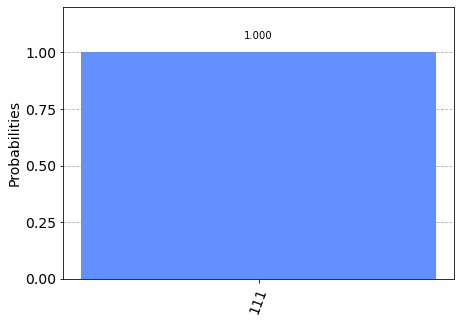

In [24]:
# utiluser simulateur locale
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(dj_circuit, qasm_sim)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

## une fonction généralisée qui crée des oracles Deutsch-Joza et les transforme en portes quantiques. Il faut que le case, (Soit 'equilibré' ou ' constant', et n, la taille du registre d'entré 

In [25]:
def dj_oracle(case, n):
    # créer un objet QuantumCircuit pour retourner
    # Ce circuit a n + 1 qubits: la taille de l'entrée,
    # plus un qubit de sortie 
    oracle_qc = QuantumCircuit(n+1)
    
    # traiter le cas où l'oracle est équilibré
    if case == "équilibré":
        # générer un nombre aléatoire qui nous indique les CNOT 
        # à envelopper dans X gates:
        b = np.random.randint(1,2**n)
        # formater 'b' comme une chaîne binaire de longueur 'n', complétée par des zéros
        b_str = format(b, '0'+str(n)+'b')
        # plaçer les premières portes X. Chaque chiffre de notre chaîne binaire 
        # correspond à un qubit, si le chiffre est 0, on ne fait rien, s'il vaut 1
        # nous appliquons un X gate à ce qubit: 
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
       # les portes contrôlées NON pour chaque qubit, en utilisant le qubit de sortie
       # comme cible:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # placer les X gates finale
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Cas dans lequel un oracle est constant
    if case == "constant":
        # Décidez d'abord de la sortie fixe de l'oracle
        # soit toujours 0, soit toujours 1) 
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

###### Créer également une fonction qui prend cette porte oracle et exécute l'algorithme Deutsch-Joza

In [26]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # qubit de sortie:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # registre d'entrée:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Ajouter la porte oracle au circuit:
    dj_circuit.append(oracle, range(n+1))
    # effectuer à nouveau les portes en H et mesurer:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [27]:
# utiliser ces fonctions pour l'algorithme
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c: 4/═══════════════════════════╩══╩══╩══╩═
                                0  1  2  3

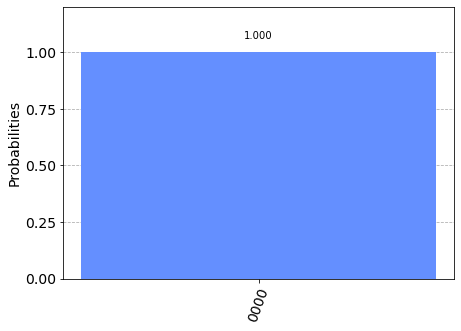

In [28]:
# voir les résultats de l'exécution de ce circuit
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

## Application de L’algorithme

### Fonction 1 : F(x1, x2) = (x1 ∩ x2) ∪ (x1 ∩ x2)  

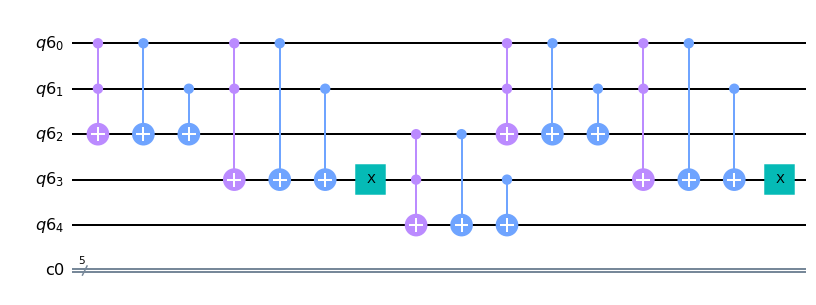

In [29]:
qr = QuantumRegister(5)
cr = ClassicalRegister(5)
qc = QuantumCircuit(qr,cr)

qc.ccx(qr[0],qr[1], qr[2])
qc.cx(qr[0],qr[2])
qc.cx(qr[1],qr[2])

qc.ccx(qr[0],qr[1], qr[3])
qc.cx(qr[0],qr[3])
qc.cx(qr[1],qr[3])
qc.x(qr[3])

qc.ccx(qr[2],qr[3], qr[4])
qc.cx(qr[2],qr[4])
qc.cx(qr[3],qr[4])

qc.ccx(qr[0],qr[1], qr[2])
qc.cx(qr[0],qr[2])
qc.cx(qr[1],qr[2])

qc.ccx(qr[0],qr[1], qr[3])
qc.cx(qr[0],qr[3])
qc.cx(qr[1],qr[3])
qc.x(qr[3])

qc.draw('mpl')

### Utilisez l’algorithme de Deutsh-Jozsa pour tester  la fonction

In [30]:
n = 4
oracle_gate = dj_oracle(qc, n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c: 4/═══════════════════════════╩══╩══╩══╩═
                                0  1  2  3

### Fonction 2 : F(x1, x2) = (x1 ∩ x2) ∪ (x1 ∩ x2)

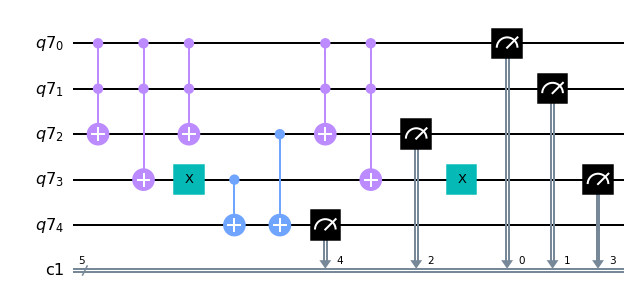

In [31]:
qr = QuantumRegister(5)
cr = ClassicalRegister(5)
# Create a Quantum Circuit acting on a quantum register of two qubits"quantumregister" et deux bit "classicalRegister"
qc=QuantumCircuit(qr,cr)
qc.ccx(qr[0],qr[1], qr[2])

qc.ccx(qr[0],qr[1], qr[3])
qc.x(qr[3])

qc.ccx(qr[0],qr[1], qr[2])
qc.cx(qr[3],qr[4])
qc.cx(qr[2],qr[4])

qc.ccx(qr[0],qr[1], qr[2])
qc.ccx(qr[0],qr[1], qr[3])
qc.x(qr[3])

qc.measure(qr[0],cr[0])
qc.measure(qr[1],cr[1])
qc.measure(qr[2],cr[2])
qc.measure(qr[3],cr[3])
qc.measure(qr[4],cr[4])

qc.draw('mpl')

### tester la fonction

In [32]:
n = 4
oracle_gate = dj_oracle(qc, n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c: 4/═══════════════════════════╩══╩══╩══╩═
                                0  1  2  3